In [1]:
import numpy as np
import math
import sys
import ipdb

sys.path.append("../")

sys.path.append("../utils/")
from utils_functions import *

from dd_game import *
from two_stage_player import *
from dfo_player import *
from solo_player import *

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
plt.rcParams['font.size'] = 20
plt.rcParams['axes.linewidth'] = 3

In [2]:
np.random.seed(63)

d_1 = 2  # Dimension of each player's data/strategy
d_2 = 2

epsilon_0 = 0.1
epsilon_1 = 1  # Epsilon sensitivity parameters
epsilon_2 = 1

Sigma_x_p1 = np.eye(d_1)  # Covariance of x^k
Sigma_x_p2 = np.eye(d_2)

sigma_y_p1 = 0.1  # Variance of y^k
sigma_y_p2 = 0.1

beta_p1 = sample_sphere(1,d_1)
beta_p2 = sample_sphere(1,d_2)

# s_1 = sample_sphere(epsilon_1,d_1+d_2)  # Performativity parameters
# mu_p1 = s_1[0:d_1]
# gamma_p1 = s_1[d_1:]
# s_2 = sample_sphere(epsilon_2,d_1+d_2)
# mu_p2 = s_2[0:d_2]
# gamma_p2 = s_2[d_2:]

mu_p1 = sample_sphere(epsilon_0,d_1)
gamma_p1 = sample_sphere(epsilon_1,d_2)
mu_p2 = sample_sphere(epsilon_0,d_2)
gamma_p2 = sample_sphere(epsilon_2,d_1)

p1_data_params = (Sigma_x_p1, sigma_y_p1, beta_p1, mu_p1, gamma_p1)
p1_data_generating_func = sample_from_location_family

p2_data_params = (Sigma_x_p2, sigma_y_p2, beta_p2, mu_p2, gamma_p2)
p2_data_generating_func = sample_from_location_family

N1 = 500
N2 = 10

num_rounds_lst = np.logspace(1.7,5,N2,dtype='int')
# num_rounds_lst = [50, 100, 500, 1000, 5000, 10000, 50000, 100000]
num_alternate_rounds = 1000
num_test = 1000

In [3]:
p1_risks = np.zeros((N1,N2))
p2_risks = np.zeros((N1,N2))
theta_final_p1 = np.zeros((N1,N2,d_1))
theta_final_p2 = np.zeros((N1,N2,d_2))

delta = 1e-0
eta = 1e-1
num_rounds = num_rounds_lst[-1]

for j in range(N1):
    print(j)
    player_one = DFOPlayer(delta,eta)
    player_two = DFOPlayer(delta,eta)
    game_dfo = DecisionDependentGame(player_one, player_two,
                                     p1_data_params, p2_data_params,
                                     p1_data_generating_func, p2_data_generating_func)

    for i in range(num_rounds+1):
        game_dfo.theta_p1 = player_one.perturb_theta()
        game_dfo.theta_p2 = player_two.perturb_theta()

        PR_1_oracle, PR_2_oracle = game_dfo.evaluate_closed_perf_risk()

        game_dfo.theta_p1 = player_one.update_theta(PR_1_oracle)
        game_dfo.theta_p2 = player_two.update_theta(PR_2_oracle)

        if i in num_rounds_lst:
            p1_risks[j,np.where(num_rounds_lst==i)] = PR_1_oracle
            p2_risks[j,np.where(num_rounds_lst==i)] = PR_2_oracle

            theta_final_p1[j,np.where(num_rounds_lst==i)] = game_dfo.theta_p1
            theta_final_p2[j,np.where(num_rounds_lst==i)] = game_dfo.theta_p2

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [4]:
# np.random.seed(63)

p3_risks = np.zeros((N1,N2))
p4_risks = np.zeros((N1,N2))
theta_final_p3 = np.zeros((N1,N2,d_1))
theta_final_p4 = np.zeros((N1,N2,d_2))

for i in range(N1):
    print(i)
    for num_rounds in num_rounds_lst:
#         print(f"num_rounds = {num_rounds}")
        player_three = TwoStagePlayer()
        player_four = TwoStagePlayer()
        game = DecisionDependentGame(player_three, player_four,
                                     p1_data_params, p2_data_params,
                                     p1_data_generating_func, p2_data_generating_func,
                                     num_rounds, num_alternate_rounds, num_test)

        game.run_train()
        game.run_post_train_alternating()

        PR3, PR4 = game.evaluate_closed_perf_risk()
        p3_risks[i,np.where(num_rounds_lst==num_rounds)] = PR3
        p4_risks[i,np.where(num_rounds_lst==num_rounds)] = PR4

        theta_final_p3[i,np.where(num_rounds_lst==num_rounds)] = game.theta_p1
        theta_final_p4[i,np.where(num_rounds_lst==num_rounds)] = game.theta_p2

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [5]:
p1_risks[np.isinf(p1_risks)]=np.nan
p2_risks[np.isinf(p2_risks)]=np.nan
p3_risks[np.isinf(p3_risks)]=np.nan
p4_risks[np.isinf(p4_risks)]=np.nan

theta_PO_1, theta_PO_2 = game.solve_nash()
theta_SO_1, theta_SO_2 = game.solve_social_opt()

game.theta_p1, game.theta_p2 = game.solve_nash()
PO_1, PO_2 = game.evaluate_closed_perf_risk()
print(f'Player 1 PO = {PO_1.round(3)}\tPlayer 2 PO = {PO_2.round(3)}')

game.theta_p1, game.theta_p2 = game.solve_social_opt()
SO_1, SO_2 = game.evaluate_closed_perf_risk()
print(f'Player 1 SO = {SO_1.round(3)}\tPlayer 2 SO = {SO_2.round(3)}')

Player 1 PO = 0.479	Player 2 PO = 0.159
Player 1 SO = 0.172	Player 2 SO = 0.194


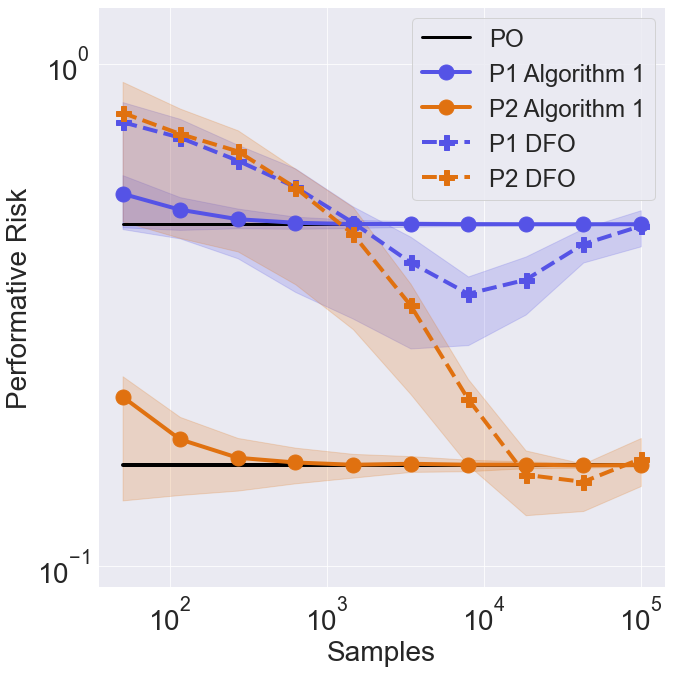

In [42]:
plt.rcParams['font.size'] = 28
plt.rcParams['axes.linewidth'] = 4
plt.figure(figsize=(10,10))
# plt.subplot(2,1,1)
# plt.semilogx(num_rounds_lst, [PO_1 for i in num_rounds_lst],
#              '-', color='k', label='P1 Performative Optimum')
# plt.semilogx(num_rounds_lst, [PO_2 for i in num_rounds_lst],
#              '-', color='k', label='P2 Performative Optimum') 

# plt.semilogx(num_rounds_lst, p1_risks,
#              '--', color='#5553E6', label='P1 Solo Performative Risk')
# plt.semilogx(num_rounds_lst, p2_risks,
#              '--', color='#E07110', label='P2 2S Performative Risk')

# plt.semilogx(num_rounds_lst, p3_risks,
#              '-', color='#5553E6', label='P1 2S Performative Risk')
# plt.semilogx(num_rounds_lst, p4_risks,
#              '-', color='#E07110', label='P2 2S Performative Risk')
# plt.ylabel(r"$PR(\theta)$")
# plt.legend(fontsize=14)

# plt.subplot(2,1,2)
plt.loglog(num_rounds_lst, [PO_1 for i in num_rounds_lst],
           '-', color='k', label='PO', lw=3)
plt.loglog(num_rounds_lst, [PO_2 for i in num_rounds_lst],
           '-', color='k', lw=4)

# plt.loglog(num_rounds_lst, p1_risks,
#            '--', color='#5553E6', label='P1 Solo Performative Risk')
# plt.loglog(num_rounds_lst, p2_risks,
#            '--', color='#E07110', label='P2 2S Performative Risk')

plt.loglog(num_rounds_lst, np.nanmean(p3_risks,axis=0),
           '-', color='#5553E6', label='P1 Algorithm 1', lw=4, marker='o',markersize=15)
plt.fill_between(num_rounds_lst, np.sort(p3_risks,axis=0)[math.floor(N1*0.34)],
                 np.sort(p3_risks,axis=0)[-math.ceil(N1*0.34)],
                 alpha=0.2, color='#5553E6')
plt.loglog(num_rounds_lst, np.nanmean(p4_risks,axis=0),
           '-', color='#E07110', label='P2 Algorithm 1', lw=4, marker='o',markersize=15)
plt.fill_between(num_rounds_lst, np.sort(p4_risks,axis=0)[math.floor(N1*0.34)],
                 np.sort(p4_risks,axis=0)[-math.ceil(N1*0.34)],
                 alpha=0.2, color='#E07110')

plt.loglog(num_rounds_lst, np.nanmean(p1_risks,axis=0),
           '--', color='#5553E6', label='P1 DFO', lw=4, marker='P',markersize=15)
plt.fill_between(num_rounds_lst, np.sort(p1_risks,axis=0)[math.floor(N1*0.34)],
                 np.sort(p1_risks,axis=0)[-math.ceil(N1*0.34)],
                 alpha=0.2, color='#5553E6')
plt.loglog(num_rounds_lst, np.nanmean(p2_risks,axis=0),
           '--', color='#E07110', label='P2 DFO', lw=4, marker='P',markersize=15)
plt.fill_between(num_rounds_lst, np.sort(p2_risks,axis=0)[math.floor(N1*0.34)],
                 np.sort(p2_risks,axis=0)[-math.ceil(N1*0.34)],
                 alpha=0.2, color='#E07110')

plt.ylabel("Performative Risk")
plt.xlabel("Samples")
plt.legend(loc='upper right',fontsize=24)
plt.ylim(0.09,1.3)
plt.tight_layout()
plt.savefig('../figures/dfo_vs_2stage_convergence.pdf', format='pdf')
plt.show()

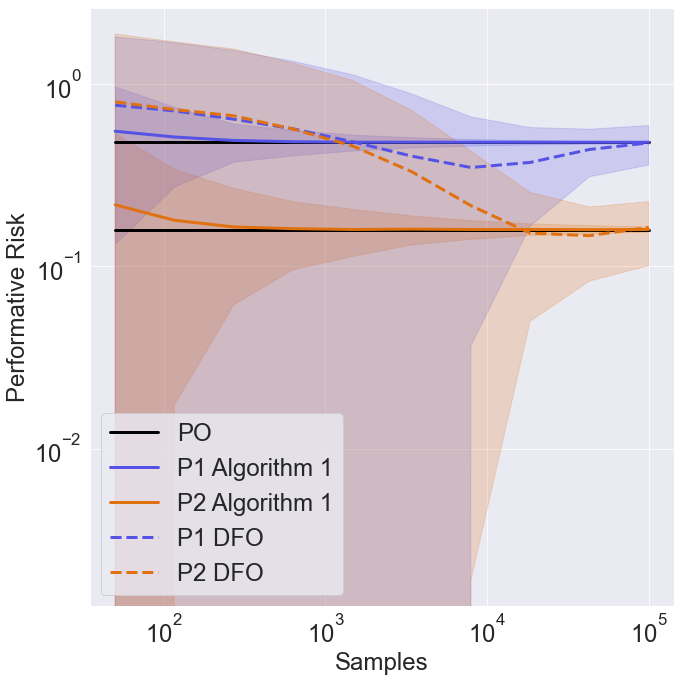

In [26]:
plt.rcParams['font.size'] = 24
plt.rcParams['axes.linewidth'] = 3
plt.figure(figsize=(10,10))

plt.loglog(num_rounds_lst, [PO_1 for i in num_rounds_lst],
           '-', color='k', label='PO', lw=3)
plt.loglog(num_rounds_lst, [PO_2 for i in num_rounds_lst],
           '-', color='k', lw=3)

plt.loglog(num_rounds_lst, np.nanmean(p3_risks,axis=0),
           '-', color='#5553E6', label='P1 Algorithm 1', lw=3)
plt.fill_between(num_rounds_lst, np.nanmean(p3_risks,axis=0)-2*np.sqrt(np.nanvar(p3_risks,axis=0)),
                 np.nanmean(p3_risks,axis=0)+2*np.sqrt(np.nanvar(p3_risks,axis=0)),
                 alpha=0.2, color='#5553E6')
plt.loglog(num_rounds_lst, np.nanmean(p4_risks,axis=0),
           '-', color='#E07110', label='P2 Algorithm 1', lw=3)
plt.fill_between(num_rounds_lst, np.nanmean(p4_risks,axis=0)-2*np.sqrt(np.nanvar(p4_risks,axis=0)),
                 np.nanmean(p4_risks,axis=0)+2*np.sqrt(np.nanvar(p4_risks,axis=0)),
                 alpha=0.2, color='#E07110')

plt.loglog(num_rounds_lst, np.nanmean(p1_risks,axis=0),
           '--', color='#5553E6', label='P1 DFO', lw=3)
plt.fill_between(num_rounds_lst, np.nanmean(p1_risks,axis=0)-2*np.sqrt(np.nanvar(p1_risks,axis=0)),
                 np.nanmean(p1_risks,axis=0)+2*np.sqrt(np.nanvar(p1_risks,axis=0)),
                 alpha=0.2, color='#5553E6')
plt.loglog(num_rounds_lst, np.nanmean(p2_risks,axis=0),
           '--', color='#E07110', label='P2 DFO', lw=3)
plt.fill_between(num_rounds_lst, np.nanmean(p2_risks,axis=0)-2*np.sqrt(np.nanvar(p2_risks,axis=0)),
                 np.nanmean(p2_risks,axis=0)+2*np.sqrt(np.nanvar(p2_risks,axis=0)),
                 alpha=0.2, color='#E07110')

plt.ylabel("Performative Risk")
plt.xlabel("Samples")
plt.legend(loc='best',fontsize=24)
plt.savefig('../figures/dfo_vs_2stage_convergence_var.pdf', format='pdf')
plt.tight_layout()
plt.show()

In [21]:
np.mean(np.linalg.norm(theta_final_p1-theta_PO_1,axis=2),axis=0)

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [22]:
theta_final_p1

array([[[nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan]],

       ...,

       [[nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan]]])